# MODELLER examples
- Here is an exmaple/tutorial on doing homology modeling with modeller.
- We follow in part this tutorial https://salilab.org/modeller/tutorial/basic.html

## Example 1: build a model from one structure with one chain
 - We have chicken histone H1 structure, PDB id 1HST
 - We want to build a human model of UniProtID P07305

In [7]:
# Let's get template structure
import pypdb
import nglview as nv

with open('1HST.pdb','w') as f:
    f.write(pypdb.get_pdb_file('1HST', filetype='pdb', compression=False))

In [14]:
#Let's get template sequence
from Bio.PDB import *
#See docs here https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
p = PDBParser()
structure = p.get_structure('H1', '1HST.pdb')
ppb = PPBuilder()
for pp in ppb.build_peptides(structure):
    print(pp.get_sequence())
# Let's view structure
nv.show_biopython(structure)

SHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLAAGVLKQTKGVGASGSFRLAK
SHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLAAGVLKQTKGVGASGSFRLAK


NGLWidget()

In [11]:
#Let's get target seqeunce
from Bio import SeqIO
import urllib.request
handle = urllib.request.urlopen("http://www.uniprot.org/uniprot/P07305.xml")
record = SeqIO.read(handle, "uniprot-xml")
#print(record)
print(record.name)
print(record.seq)

H10_HUMAN
MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADSQIKLSIKRLVTTGVLKQTKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKAASKAPTKKPKATPVKKAKKKLAATPKKAKKPKTVKAKPVKASKPKKAKPVKPKAKSSAKRAGKKK


A tricky thing about MODELLER is the preparation of sequences and/or alignment files in PIR-like-format with additional information.
Here is an example
```
>P1;TvLDH
sequence:TvLDH:::::::0.00: 0.00
MSEAAHVLITGAAGQIGYILSHWIASGELYGDRQVYLHLLDIPPAMNRLTALTMELEDCAFPHLAGFVATTDPKA
AFKDIDCAFLVASMPLKPGQVRADLISSNSVIFKNTGEYLSKWAKPSVKVLVIGNPDNTNCEIAMLHAKNLKPEN
FSSLSMLDQNRAYYEVASKLGVDVKDVHDIIVWGNHGESMVADLTQATFTKEGKTQKVVDVLDHDYVFDTFFKKI
GHRAWDILEHRGFTSAASPTKAAIQHMKAWLFGTAPGEVLSMGIPVPEGNPYGIKPGVVFSFPCNVDKEGKIHVV
EGFKVNDWLREKLDFTEKDLFHEKEIALNHLAQGG*
```
The first line contains the sequence code, in the format ">P1;code". The second line with ten fields separated by colons generally contains information about the structure file, if applicable. Only two of these fields are used for sequences, "sequence" (indicating that the file contains a sequence without known structure) and "TvLDH" (the model file name). The rest of the file contains the sequence of TvLDH, with "*" marking its end. The standard one-letter amino acid codes are used. (Note that they must be upper case; some lower case letters are used for non-standard residues. See the file modlib/restyp.lib in the Modeller distribution for more information.)

- Here is decription https://salilab.org/modeller/manual/node496.html#alignmentformat

In [40]:
record.name='sequence:model_file_name::::::::'
record.description=''
record.id='humanH1'

In [41]:
handle = open('humanH1.ali', "w")
writer = SeqIO.PirIO.PirWriter(handle)
writer.write_file([record])
handle.close()
!cat humanH1.ali

>P1;humanH1
sequence:model_file_name::::::::
MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKV
GENADSQIKLSIKRLVTTGVLKQTKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATP
KKASKPKKAASKAPTKKPKATPVKKAKKKLAATPKKAKKPKTVKAKPVKASKPKKAKPVK
PKAKSSAKRAGKKK*


In [43]:
#Now we'll do alignment using Modeller
from modeller import *

env = environ()
aln = alignment(env)
mdl = model(env, file='1HST', model_segment=('FIRST:A','LAST:A'))
aln.append_model(mdl, align_codes='1HSTA', atom_files='1HST.pdb')
aln.append(file='humanH1.ali', align_codes='humanH1')
aln.align2d()
aln.write(file='humanH1-1HSTA.ali', alignment_format='PIR')
aln.write(file='humanH1-1HSTA.pap', alignment_format='PAP')

mkapsa__637W> No residue topology library is in memory.
              Better radii would be used if topology.read() is called first.
iup2crm_280W> No topology library in memory or assigning a BLK residue.
              Default CHARMM atom type assigned:  N -->  N
              This message is written only for the first such atom.

Pairwise dynamic programming alignment (ALIGN2D):
  Residue-residue metric   : $(LIB)/as1.sim.mat
  Diagonal                 :          100
  Overhang                 :            0
  Maximal gap length       :       999999
  Local alignment          :            F
  MATRIX_OFFSET (local aln):       0.0000
  FIX_OFFSETS              :      0.0    -1.0    -2.0    -3.0    -4.0
  N_SUBOPT                 :            0
  SUBOPT_OFFSET            :       0.0000
  Alignment block          :            1
  Gap introduction penalty :    -100.0000
  Gap extension penalty    :       0.0000
  Gap diagonal penalty     :       0.0000
  Structure gap penalties  :    3.500

In [45]:
#Let's run MODELLER
from modeller import *
from modeller.automodel import *

env = environ()
a = automodel(env, alnfile='humanH1-1HSTA.ali',
              knowns=('1HSTA'), sequence='humanH1',
              assess_methods=(assess.DOPE,assess.GA341))
a.starting_model = 1
a.ending_model = 5
a.make()


check_ali___> Checking the sequence-structure alignment. 

Implied intrachain target CA(i)-CA(i+1) distances longer than  8.0 angstroms:

ALN_POS  TMPL  RID1  RID2  NAM1  NAM2     DIST
----------------------------------------------
END OF TABLE
read_to_681_> topology.submodel read from topology file:        3
mdtrsr__446W> A potential that relies on one protein is used, yet you have at
              least one known structure available. MDT, not library, potential is used.
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies
condens_443_> Restraints marked for deletion were removed.
              Total number of restraints before, now:    10799     9324
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in 




List of the violated restraints:
   A restraint is violated when the relative difference
   from the best value (RVIOL) is larger than CUTOFF.

   ICSR   ... index of a restraint in the current set.
   RESNO  ... residue numbers of the first two atoms.
   ATM    ... IUPAC atom names of the first two atoms.
   FEAT   ... the value of the feature in the model.
   restr  ... the mean of the basis restraint with the smallest
              difference from the model (local minimum).
   viol   ... difference from the local minimum.
   rviol  ... relative difference from the local minimum.
   RESTR  ... the best value (global minimum).
   VIOL   ... difference from the best value.
   RVIOL  ... relative difference from the best value.


-------------------------------------------------------------------------------------------------

Feature 25                           : Phi/Psi pair of dihedral restraints     
List of the RVIOL violations larger than   :       6.5000

    #   ICSR  RESNO1

>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      194
Number of all, selected real atoms                :     1466    1466
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :     9324    9324
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   124513
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                              

DISTANCE1:  0.00 2.10 2.20 2.30 2.40 2.50 2.60 2.70 2.80 2.90 3.00 3.10 3.20 3.30 3.40
DISTANCE2:  2.10 2.20 2.30 2.40 2.50 2.60 2.70 2.80 2.90 3.00 3.10 3.20 3.30 3.40 3.50
FREQUENCY:     0    0    0    0    0    5   16   44   62  104   91  132  133  131  173


<< end of ENERGY.
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      194
Number of all, selected real atoms                :     1466    1466
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :     9324    9324
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   120592
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts 

>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      194
Number of all, selected real atoms                :     1466    1466
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :     9324    9324
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   119819
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                              

>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      194
Number of all, selected real atoms                :     1466    1466
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :     9324    9324
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   139785
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH                              :    6.500   7.500
COULOMB_JONES_SWITCH                              :    6.500   7.500
RESIDUE_SPAN_RANGE                                :        1    9999
NLOGN_USE                              

In [49]:
mod_f_name_0=a.outputs[0]['name']
mod_f_name_0

'humanH1.B99990001.pdb'

In [55]:
#Let's do some evaluations
from modeller import *
from modeller.scripts import complete_pdb

log.verbose()    # request verbose output
env = environ()
env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters

# read model file
mdl = complete_pdb(env, mod_f_name_0)

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='model.profile',
              normalize_profile=True, smoothing_window=15)

# read model file
mdl = complete_pdb(env, '1HST.pdb')

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='1HSTA.profile',
              normalize_profile=True, smoothing_window=15)

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15537215   15173.062    14.817

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15537743   15173.577    14.818
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15586343   15221.038    14.864
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15599643   15234.026    14.877
openf___224_> Open           $

31 Non-bonded restraints              :  125515       0    311   6.447   6.447     -9055.2       1.000
32 Atomic accessibility restraints    :       0       0      0   0.000   0.000      0.0000       0.000
33 Atomic density restraints          :       0       0      0   0.000   0.000      0.0000       0.000
34 Absolute position restraints       :       0       0      0   0.000   0.000      0.0000       0.000
35 Dihedral angle difference restraint:       0       0      0   0.000   0.000      0.0000       0.000
36 GBSA implicit solvent potential    :       0       0      0   0.000   0.000      0.0000       0.000
37 EM density fitting potential       :       0       0      0   0.000   0.000      0.0000       0.000
38 SAXS restraints                    :       0       0      0   0.000   0.000      0.0000       0.000
39 Symmetry restraints                :       0       0      0   0.000   0.000      0.0000       0.000
do_prof_492W> Are you sure you want to calculate a normalized energy prof

31 Non-bonded restraints              :  177314       0    129   6.684   6.684     -14587.       1.000
32 Atomic accessibility restraints    :       0       0      0   0.000   0.000      0.0000       0.000
33 Atomic density restraints          :       0       0      0   0.000   0.000      0.0000       0.000
34 Absolute position restraints       :       0       0      0   0.000   0.000      0.0000       0.000
35 Dihedral angle difference restraint:       0       0      0   0.000   0.000      0.0000       0.000
36 GBSA implicit solvent potential    :       0       0      0   0.000   0.000      0.0000       0.000
37 EM density fitting potential       :       0       0      0   0.000   0.000      0.0000       0.000
38 SAXS restraints                    :       0       0      0   0.000   0.000      0.0000       0.000
39 Symmetry restraints                :       0       0      0   0.000   0.000      0.0000       0.000
do_prof_492W> Are you sure you want to calculate a normalized energy prof

-14587.330078125

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15859881   15488.165    15.125

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15860409   15488.681    15.126
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15909009   15536.142    15.172
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     15922309   15549.130    15.185
openf___224_> Open           $

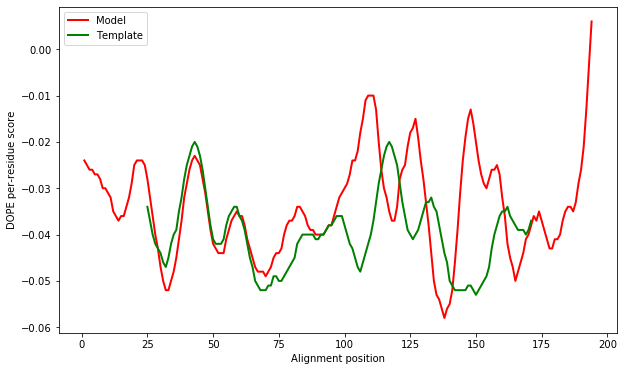

In [57]:
%matplotlib inline
import pylab
import modeller

def r_enumerate(seq):
    """Enumerate a sequence in reverse order"""
    # Note that we don't use reversed() since Python 2.3 doesn't have it
    num = len(seq) - 1
    while num >= 0:
        yield num, seq[num]
        num -= 1

def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in r_enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals

e = modeller.environ()
a = modeller.alignment(e, file='humanH1-1HSTA.ali')

template = get_profile('1HSTA.profile', a['1HSTA'])
model = get_profile('model.profile', a['humanH1'])

# Plot the template and model profiles in the same plot for comparison:
pylab.figure(1, figsize=(10,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(template, color='green', linewidth=2, label='Template')
pylab.legend()
pylab.show()
# pylab.savefig('dope_profile.png', dpi=65)
